In [1]:
import os
import errno
import numpy as np 
import deepcell
from deepcell_toolbox.processing import phase_preprocess

In [2]:
# create folder for this set of experiments
experiment_folder = "20200619_production_updates"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
NPZ_DIR = "/data/npz_data/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [3]:
# npz1 = np.load(NPZ_DIR + '/20200724_COH_BC.npz')
# npz2 = np.load(NPZ_DIR + '/20200720_all_data_512x512.npz')
# combined_x = np.concatenate((npz1['X'], npz2['X']), axis=0)
# combined_y = np.concatenate((npz1['y'], npz2['y']), axis=0)

# print(combined_x.shape, combined_y.shape)

(960, 512, 512, 2) (960, 512, 512, 1)


In [4]:
# np.savez_compressed(NPZ_DIR + '/20200730_all_data_512x512.npz', X=combined_x, y=combined_y)

In [3]:
from deepcell.utils.data_utils import get_data
from skimage.segmentation import relabel_sequential

npz_name = "20200816_all_data_normalized_512x512"

test_size=0.1
seed=0
DATA_FILE = NPZ_DIR + npz_name + ".npz"
train_dict, val_dict = get_data(DATA_FILE, test_size=test_size, seed=seed)
X_train, y_train = train_dict['X'], train_dict['y']
X_val, y_val = val_dict['X'], val_dict['y']

In [4]:
np.savez_compressed(NPZ_DIR + npz_name + 'val_split.npz', X=X_val, y=y_val)

X.shape: (864, 512, 512, 2)
y.shape: (864, 512, 512, 1)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]


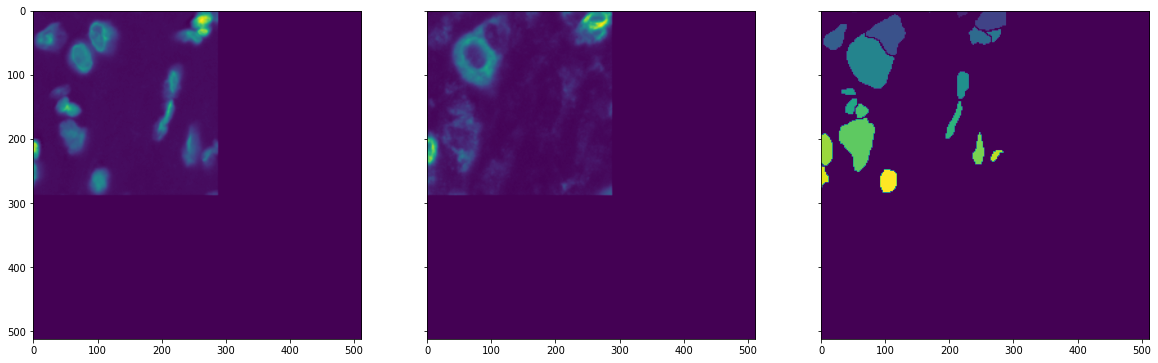

In [4]:
for i in range(y_train.shape[0]):
        y_train[i], _, _ = relabel_sequential(y_train[i])
        
for i in range(y_val.shape[0]):
        y_val[i], _, _ = relabel_sequential(y_val[i])
        
               
print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 20), sharex=True, sharey=True)

idx = 107
axes[0].imshow(X_train[idx,:,:,0].astype('float32'))
axes[1].imshow(X_train[idx,:,:,1].astype('float32'))
axes[2].imshow(y_train[idx,:,:,0].astype('float32'))
print(np.unique(y_train[idx]))

In [4]:
k=128
X_train = phase_preprocess(X_train, k)
X_val = phase_preprocess(X_val, k)

In [12]:
from deepcell.model_zoo.panopticnet import PanopticNet

new_model = PanopticNet(
    backbone='resnet50',
    input_shape=(256, 256, 2),
    norm_method=None,
    num_semantic_heads=4,
    num_semantic_classes=[1, 1, 2, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True)

In [13]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = npz_name + '_deep_watershed'

n_epoch = 100  # Number of training epochs

optimizer = Adam(lr=1e-4, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-4, decay=0.99)

batch_size = 8

min_objects = 30  # throw out images with fewer than this many objects
seed=0
model_name

'20200816_all_data_normalized_512x512_deep_watershed'

In [7]:
from deepcell import image_generators
from deepcell.utils import train_utils


# use augmentation for training but not validation
datagen = image_generators.CroppingDataGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True,
    crop_size=(256, 256))

datagen_val = image_generators.CroppingDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0,
    crop_size=(256, 256))
    
train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=['inner-distance', 'watershed-cont', 'fgbg', 'pixelwise'],
    transforms_kwargs={'watershed-cont': {'erosion_width': 1}, 'pixelwise':{'dilation_radius': 1}, 
                      'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_val, 'y': y_val},
    seed=seed,
    transforms=['inner-distance', 'watershed-cont', 'fgbg', 'pixelwise'],
    transforms_kwargs={'watershed-cont': {'erosion_width': 1}, 'pixelwise':{'dilation_radius': 1},
                      'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    min_objects=min_objects,
    batch_size=batch_size)

W0816 17:24:25.397160 140659005892416 semantic.py:158] Removing 409 of 2291 images with fewer than 30 objects.
W0816 17:25:27.817174 140659005892416 semantic.py:158] Removing 51 of 255 images with fewer than 30 objects.


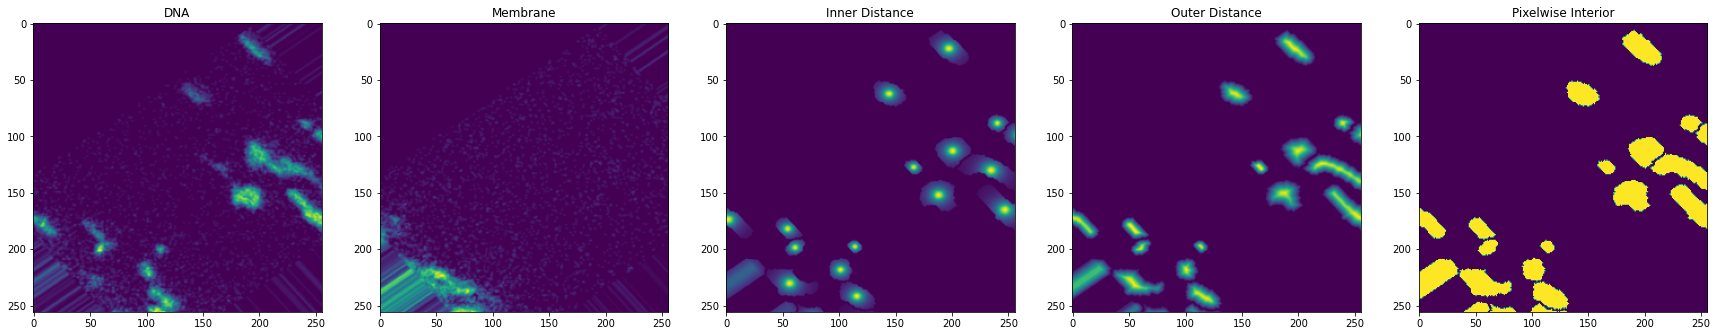

In [8]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]
pixelwise = outputs[3]

fig, axes = plt.subplots(1, 5, figsize=(30, 30))

axes[0].imshow(img[:, :, 0])
axes[0].set_title('DNA')

axes[1].imshow(img[:, :, 1])
axes[1].set_title('Membrane')

axes[2].imshow(inner_distance[0, ..., 0])
axes[2].set_title('Inner Distance')

axes[3].imshow(outer_distance[0, ..., 0])
axes[3].set_title('Outer Distance')

axes[4].imshow(pixelwise[0, ..., 1])
axes[4].set_title('Pixelwise Interior')

plt.show()

In [14]:
# Create a dictionary of losses for each semantic head
from tensorflow.python.keras.losses import MSE
from deepcell import losses


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in new_model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

In [15]:
new_model.compile(loss=loss, optimizer=optimizer)

In [16]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus


model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    tensorboard_log_dir=LOG_DIR,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = new_model.fit_generator(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/100
234/235 [============================>.] - ETA: 0s - loss: 0.0577 - semantic_0_loss: 0.0173 - semantic_1_loss: 0.0311 - semantic_2_loss: 0.0027 - semantic_3_loss: 0.0067
Epoch 00001: val_loss improved from inf to 0.19989, saving model to /data/models/20200619_production_updates/20200816_all_data_normalized_512x512_deep_watershed.h5
235/235 [==============================] - 190s 808ms/step - loss: 0.0577 - semantic_0_loss: 0.0172 - semantic_1_loss: 0.0311 - semantic_2_loss: 0.0027 - semantic_3_loss: 0.0067 - val_loss: 0.1999 - val_semantic_0_loss: 0.0402 - val_semantic_1_loss: 0.0828 - val_semantic_2_loss: 0.0348 - val_semantic_3_loss: 0.0421
Epoch 2/100
234/235 [============================>.] - ETA: 0s - loss: 0.0390 - semantic_0_loss: 0.0119 - semantic_1_loss: 0.0196 - semantic_2_loss: 0.0020 - semantic_3_loss: 0.0056
Epoch 00002: val_loss improved from 0.19989 to 0.18169, saving model to /data/models/20200619_production_updates/20200816_all_data_norm

234/235 [============================>.] - ETA: 0s - loss: 0.0289 - semantic_0_loss: 0.0086 - semantic_1_loss: 0.0141 - semantic_2_loss: 0.0016 - semantic_3_loss: 0.0047
Epoch 00028: val_loss did not improve from 0.02641
235/235 [==============================] - 65s 277ms/step - loss: 0.0289 - semantic_0_loss: 0.0086 - semantic_1_loss: 0.0141 - semantic_2_loss: 0.0016 - semantic_3_loss: 0.0047 - val_loss: 0.0276 - val_semantic_0_loss: 0.0082 - val_semantic_1_loss: 0.0134 - val_semantic_2_loss: 0.0016 - val_semantic_3_loss: 0.0045
Epoch 29/100
234/235 [============================>.] - ETA: 0s - loss: 0.0292 - semantic_0_loss: 0.0086 - semantic_1_loss: 0.0142 - semantic_2_loss: 0.0016 - semantic_3_loss: 0.0047
Epoch 00029: val_loss did not improve from 0.02641
235/235 [==============================] - 65s 277ms/step - loss: 0.0292 - semantic_0_loss: 0.0086 - semantic_1_loss: 0.0142 - semantic_2_loss: 0.0016 - semantic_3_loss: 0.0047 - val_loss: 0.0274 - val_semantic_0_loss: 0.0080 - v

Epoch 43/100
234/235 [============================>.] - ETA: 0s - loss: 0.0285 - semantic_0_loss: 0.0084 - semantic_1_loss: 0.0139 - semantic_2_loss: 0.0016 - semantic_3_loss: 0.0046
Epoch 00043: val_loss did not improve from 0.02641
235/235 [==============================] - 64s 272ms/step - loss: 0.0285 - semantic_0_loss: 0.0084 - semantic_1_loss: 0.0139 - semantic_2_loss: 0.0016 - semantic_3_loss: 0.0046 - val_loss: 0.0270 - val_semantic_0_loss: 0.0079 - val_semantic_1_loss: 0.0131 - val_semantic_2_loss: 0.0016 - val_semantic_3_loss: 0.0045
Epoch 44/100
234/235 [============================>.] - ETA: 0s - loss: 0.0280 - semantic_0_loss: 0.0083 - semantic_1_loss: 0.0137 - semantic_2_loss: 0.0015 - semantic_3_loss: 0.0046
Epoch 00044: val_loss did not improve from 0.02641
235/235 [==============================] - 63s 269ms/step - loss: 0.0280 - semantic_0_loss: 0.0083 - semantic_1_loss: 0.0137 - semantic_2_loss: 0.0015 - semantic_3_loss: 0.0046 - val_loss: 0.0274 - val_semantic_0_los

Epoch 58/100
234/235 [============================>.] - ETA: 0s - loss: 0.0271 - semantic_0_loss: 0.0080 - semantic_1_loss: 0.0131 - semantic_2_loss: 0.0015 - semantic_3_loss: 0.0045
Epoch 00058: val_loss did not improve from 0.02606
235/235 [==============================] - 62s 265ms/step - loss: 0.0271 - semantic_0_loss: 0.0080 - semantic_1_loss: 0.0131 - semantic_2_loss: 0.0015 - semantic_3_loss: 0.0045 - val_loss: 0.0267 - val_semantic_0_loss: 0.0078 - val_semantic_1_loss: 0.0129 - val_semantic_2_loss: 0.0016 - val_semantic_3_loss: 0.0044
Epoch 59/100
234/235 [============================>.] - ETA: 0s - loss: 0.0277 - semantic_0_loss: 0.0082 - semantic_1_loss: 0.0135 - semantic_2_loss: 0.0015 - semantic_3_loss: 0.0046
Epoch 00059: val_loss did not improve from 0.02606
235/235 [==============================] - 63s 267ms/step - loss: 0.0277 - semantic_0_loss: 0.0081 - semantic_1_loss: 0.0135 - semantic_2_loss: 0.0015 - semantic_3_loss: 0.0046 - val_loss: 0.0271 - val_semantic_0_los

KeyboardInterrupt: 

In [19]:
new_model.load_weights(os.path.join(MODEL_DIR, '20200816_all_data_normalized_512x512_deep_watershed' + '.h5'))

In [20]:
inner_distance, outer_distance, fgbg, pixelwise = new_model.predict(X_val[:30, :256, :256, :])

In [25]:
from deepcell_toolbox.deep_watershed import deep_watershed_mibi
labeled_images = deep_watershed_mibi({'inner-distance': inner_distance,
                                     'pixelwise-interior': pixelwise[:, :, :, 1:2]}, 
                                     maxima_threshold=0.02, maxima_model_smooth=0,
                                    interior_threshold=0.3,
                                    radius=5,
                                    small_objects_threshold=10,
                                     fill_holes_threshold=10)

/usr/local/lib/python3.6/dist-packages/deepcell_toolbox/deep_watershed.py:189: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  label_image = remove_small_objects(label_image, min_size=small_objects_threshold)


In [26]:
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries
import copy
def make_color_overlay(input_data):
    """Create a color overlay from 2 channel image data
    
    Args:
        input_data: stack of input images
    
    Returns:
        numpy.array: color-adjusted stack of overlays in RGB mode
    """
    RGB_data = np.zeros(input_data.shape[:3] + (3, ), dtype='float32')
    
    # rescale channels to aid plotting
    for img in range(input_data.shape[0]):
        for channel in range(input_data.shape[-1]):
            # get histogram for non-zero pixels
            percentiles = np.percentile(input_data[img, :, :, channel][input_data[img, :, :, channel] > 0],
                                            [5, 95])
            rescaled_intensity = rescale_intensity(input_data[img, :, :, channel],
                                                       in_range=(percentiles[0], percentiles[1]),
                                                       out_range='float32')
            RGB_data[img, :, :, channel + 1] = rescaled_intensity
        
    # create a blank array for red channel
    return RGB_data

def make_outline_overlay(RGB_data, predictions):
    boundaries = np.zeros_like(predictions)
    overlay_data = copy.copy(RGB_data)
    
    for img in range(predictions.shape[0]):
        boundary = find_boundaries(predictions[img], connectivity=1, mode='inner')
        boundaries[img, boundary > 0] = 1

    overlay_data[boundaries > 0, :] = 1
    
    return overlay_data

In [27]:
RGB_data = make_color_overlay(X_val[:, :256, :256, :])
true_overlay = make_outline_overlay(RGB_data, y_val[:, :256, :256, 0])

In [28]:
predicted_overlay = make_outline_overlay(RGB_data[:30], labeled_images[..., 0])

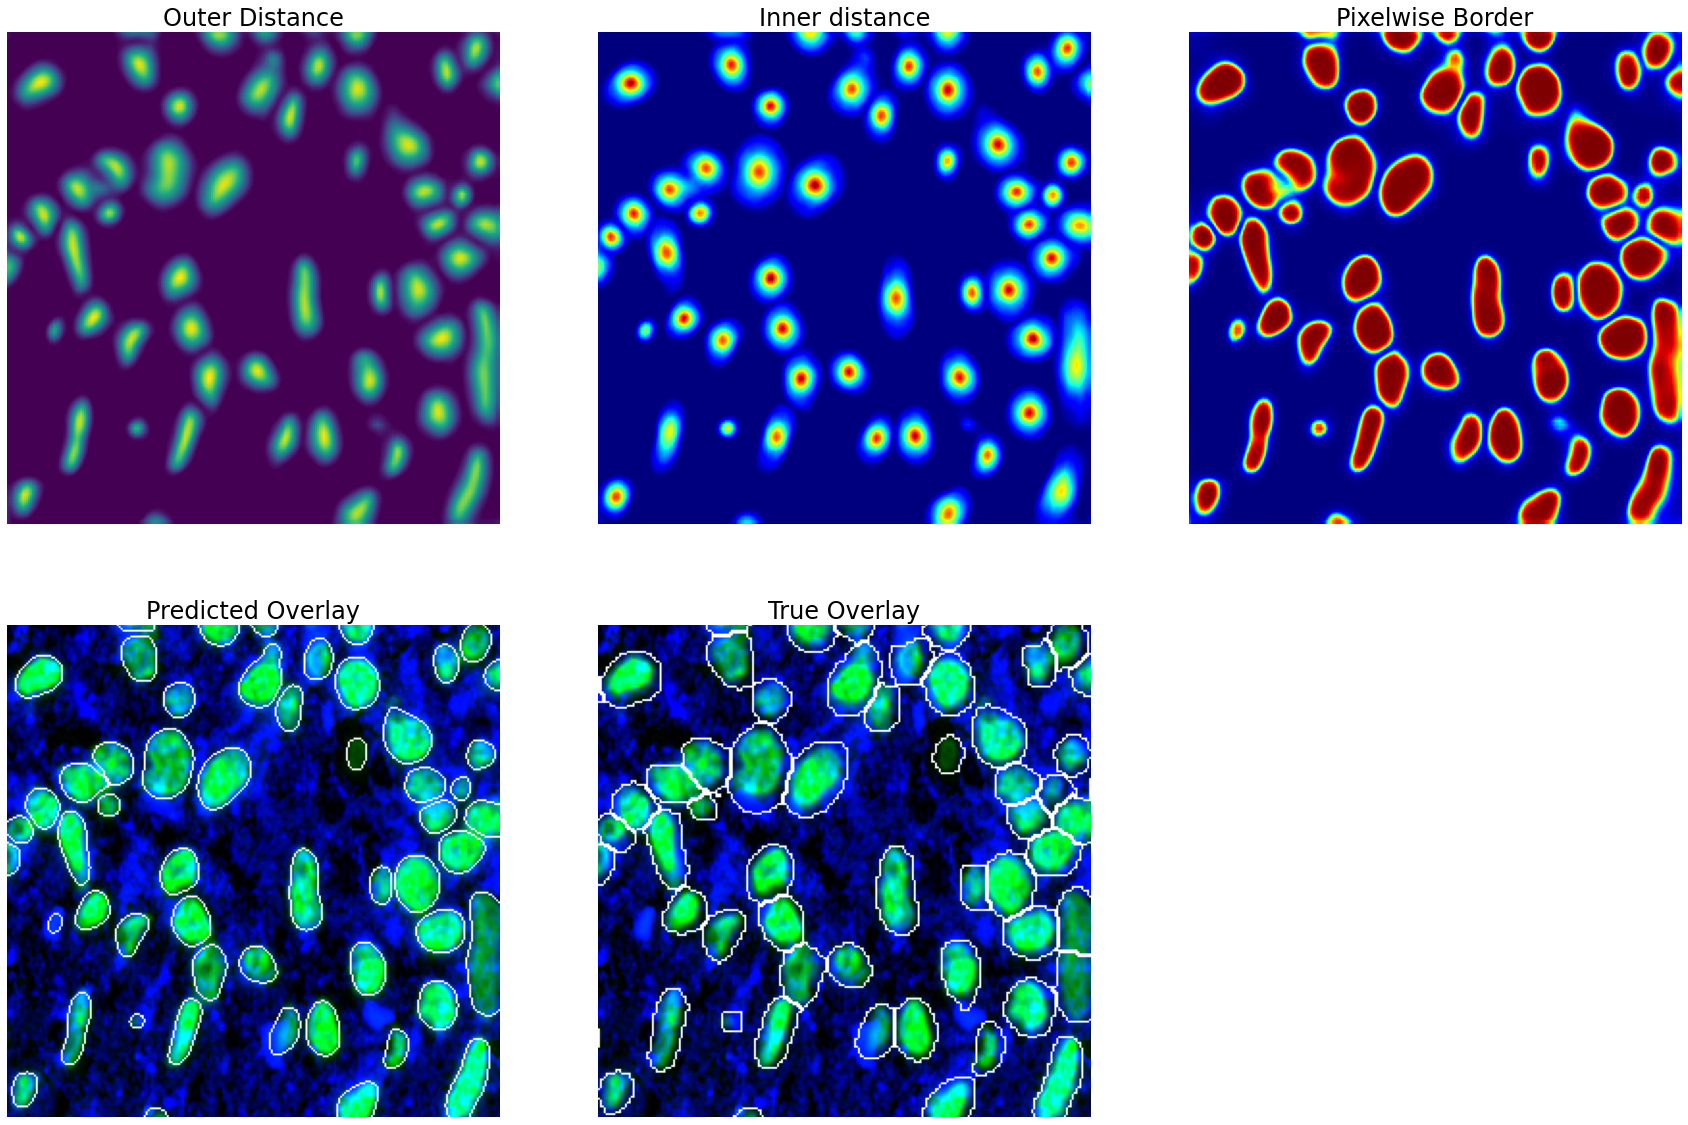

In [35]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = [27]
fig, axes = plt.subplots(2,3,figsize=(30,20))

axes = axes.flatten()
axes[0].imshow(outer_distance[index[0],..., 0])
axes[1].imshow(inner_distance[index[0],...,0], cmap='jet')
axes[2].imshow(pixelwise[index[0],...,1], cmap='jet')
axes[3].imshow(predicted_overlay[index[0], ...], cmap=cmap)
axes[4].imshow(true_overlay[index[0], ...], cmap=cmap)

axes[0].set_title('Outer Distance', fontsize=24)
axes[1].set_title('Inner distance', fontsize=24)
axes[2].set_title('Pixelwise Border', fontsize=24)
axes[3].set_title('Predicted Overlay', fontsize=24)
axes[4].set_title('True Overlay', fontsize=24)
# axes[5].set_title('Ground Truth Mask', fontsize=24)

for ax in axes.flatten():
    ax.set_axis_off()

In [5]:
from deepcell.applications import MultiplexSegmentation
app = MultiplexSegmentation()
app_output = app.predict(image=X_val[:10])

W0809 00:07:46.436294 140067825907520 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
from deepcell_toolbox.metrics import Metrics
m = Metrics('human vs human', seg=False)
m.calc_object_stats(y_true=y_val[:10, :, :, 0], y_pred=app_output[:, :, :, 0])
recall = m.stats['correct_detections'].sum() / m.stats['n_true'].sum()
precision = m.stats['correct_detections'].sum() / m.stats['n_pred'].sum()
f1 = 2 * precision * recall / (precision + recall)
print(f1)


____________Object-based statistics____________

Number of true cells:		 3618
Number of predicted cells:	 2834

Correct detections:  1906	Recall: 52.68103924820342598422939772717654705047607421875%
Incorrect detections: 928	Precision: 67.2547635850388161316004698164761066436767578125%

Gained detections: 300	Perc Error: 23.734177215189873777489992789924144744873046875%
Missed detections: 460	Perc Error: 36.392405063291136002590064890682697296142578125%
Merges: 397		Perc Error: 31.408227848101265777813750901259481906890869140625%
Splits: 50		Perc Error: 3.955696202531645777611402081674896180629730224609375%
Catastrophes: 57		Perc Error: 4.50949367088607555587032038602046668529510498046875%

Gained detections from splits: 55
Missed detections from merges: 615
True detections involved in catastrophes: 26
Predicted detections involved in catastrophes: 19 

Average Pixel IOU (Jaccard Index): 0.82338717453549625790998334196046926081180572509765625 

0.5908245505269685
